In [1]:
from __future__ import print_function
import time
import numpy as np
import theano
import theano.tensor as T
import lasagne

from cifar10_data import load_cifar10
import lasagne_trainer

Using gpu device 0: GRID K520 (CNMeM is enabled)


In [3]:
# verify that cuDNN is enabled
theano.sandbox.cuda.dnn.version()

(3002, 3002)

In [4]:
# set up plots

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# reload external libs during development
%load_ext autoreload
%autoreload 2

# load data

In [13]:
# get data
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


# theano input_var

In [7]:
input_var = T.tensor4('inputs')

## two-layer network

In [4]:
def create_twolayer(input_var, input_shape=(3, 32, 32),
              num_hidden_units=100, num_classes=10,
              **junk):
    # input layer
    network = lasagne.layers.InputLayer(shape=(None,) + input_shape,
                                        input_var=input_var)
    # fc-relu
    network = lasagne.layers.DenseLayer(
        network, num_units=num_hidden_units,
        nonlinearity=lasagne.nonlinearities.rectify)
    # output layer
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=num_classes,
        nonlinearity=lasagne.nonlinearities.softmax)
    return network

In [ ]:
# defaults
param=dict(reg=1e-1,
           update='momentum', momentum=0.9,
           learning_rate=1e-4, learning_rate_decay = 0.95,
           num_epochs=5)

In [ ]:
# [loss] train_acc val_acc

# 1.049 0.650 0.551
# 1.106 0.667 0.561
# => test accuracy: 0.548
param.update(reg=1e0, hidden_size=200, num_epochs=40, learning_rate=1e-4)

# 1.649 0.424 0.426
param.update(reg=1e1, hidden_size=200, num_epochs=40, learning_rate=1e-4)

# ????? 0.868 0.555
# 0.477 0.860 0.546
param.update(reg=1e-1, hidden_size=200, num_epochs=40, learning_rate=1e-4)

# ????? 0.578 0.419
param.update(reg=1e-1, hidden_size=200, num_epochs=40, learning_rate=1e-3)

# 1.054 0.566 0.505
param.update(reg=1e-1, hidden_size=200, num_epochs=40, learning_rate=1e-5)

# 0.724 0.537
param.update(reg=1e-1, hidden_size=200, num_epochs=20, learning_rate=1e-4)

# 0.606 0.530
param.update(reg=1.0, hidden_size=200, num_epochs=20, learning_rate=1e-4)

# 0.534 0.474
param.update(reg=1e-1, hidden_size=200, num_epochs=20, learning_rate=1e-5)

# 0.504 0.469
param.update(reg=1.0, hidden_size=200, num_epochs=20, learning_rate=1e-5)


In [ ]:
# two-layer

network = create_twolayer(input_var, num_hidden_units=128, num_classes=10)
# overfit check
xxx, loss_history, train_acc_history, val_acc_history = lasagne_trainer.train(
          network, input_var, X_train[:50], y_train[:50], X_val, y_val,
          learning_rate=1e-4, batch_size=10, num_epochs=10)

In [57]:


model, loss_history, train_acc_history, val_acc_history = lasagne_trainer.train(
    network, input_var, X_train, y_train, X_val, y_val,
    learning_rate=1e-4, num_epochs=10, batch_size=50)
print('%.3f' % min(loss_history), max(train_acc_history), max(val_acc_history), \
    ' '.join('%s=%s' % (k,param[k]) for k in param))

Compiling...
Training...
epoch 1 / 10 in 0.9s: cost 19.949498, train: 0.262000, val 0.229000, lr 1.000000e-04
epoch 2 / 10 in 0.9s: cost 3.706224, train: 0.279000, val 0.283000, lr 1.000000e-04
epoch 3 / 10 in 0.9s: cost 3.098231, train: 0.287000, val 0.298000, lr 1.000000e-04
epoch 4 / 10 in 0.9s: cost 2.809862, train: 0.321000, val 0.312000, lr 1.000000e-04
epoch 5 / 10 in 0.9s: cost 2.680390, train: 0.340000, val 0.306000, lr 1.000000e-04
epoch 6 / 10 in 0.9s: cost 2.550387, train: 0.336000, val 0.315000, lr 1.000000e-04
epoch 7 / 10 in 0.9s: cost 2.479211, train: 0.313000, val 0.321000, lr 1.000000e-04
epoch 8 / 10 in 0.9s: cost 2.420109, train: 0.372000, val 0.332000, lr 1.000000e-04
epoch 9 / 10 in 0.9s: cost 2.367520, train: 0.359000, val 0.355000, lr 1.000000e-04
epoch 10 / 10 in 0.9s: cost 2.320339, train: 0.364000, val 0.345000, lr 1.000000e-04
('1.633', 0.37199999690055846, 0.35499999970197677, 'crp_filter_size=7 num_fc=1 learning_rate=0.0001 batch_size=100 fc_num_units=32 n

## v1: [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
## v2: [conv-relu-pool]XN - [affine]XM - [softmax or SVM]

In [5]:
def create_v1(input_var, input_shape=(3, 32, 32),
              num_crp=1, crp_num_filters=32, crp_filter_size=5,
              num_cr=1,
              num_fc=1, fc_num_units=64,
              output_type='softmax', num_classes=10,
              **junk):
    # input layer
    network = lasagne.layers.InputLayer(shape=(None,) + input_shape,
                                        input_var=input_var)
    # conv-relu-pool layers
    for i in range(num_crp):
        network = lasagne.layers.Conv2DLayer(
            network, num_filters=crp_num_filters,
            filter_size=(crp_filter_size, crp_filter_size),
            pad='same',
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
        network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    # conv-relu
    for i in range(num_cr):
        network = lasagne.layers.Conv2DLayer(
            network, num_filters=crp_num_filters,
            filter_size=(crp_filter_size, crp_filter_size),
            pad='same',
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
    # fc-relu
    for i in range(num_fc - 1):
        network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=fc_num_units,
            nonlinearity=lasagne.nonlinearities.rectify)
    # output layer
    assert output_type=='softmax'
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=num_classes,
        nonlinearity=lasagne.nonlinearities.softmax)
    return network


In [113]:
# defaut params
param = dict(num_crp=1, crp_filter_size=7, crp_num_filters=32,
             num_fc=1, fc_num_units=32,
             reg=1e-3,
             learning_rate=1e-4, learning_rate_decay=0.95,
             momentum=0.9, momentum_decay=0.9,
             batch_size=100, num_epochs=20)

In [114]:
param.update(num_crp=3, crp_filter_size=3, crp_num_filters=128,
             num_fc=3, fc_num_units=256, num_epochs=100,
             learning_rate=1e-4, batch_size=128)

In [116]:
network = create_v1(input_var, **param)
# overfit
xxx, loss_history, train_acc_history, val_acc_history = lasagne_trainer.train(
          network, input_var, X_train[:50], y_train[:50], X_val, y_val,
          learning_rate=1e-4, batch_size=10, num_epochs=20)


Compiling...
Training...
epoch 1 / 20 in 0.9s: loss 71.401446, train: 0.140, val 0.116, lr 9.500000e-05 mom 9.100000e-01
epoch 2 / 20 in 0.9s: loss 33.159449, train: 0.100, val 0.112, lr 9.025000e-05 mom 9.190000e-01
epoch 3 / 20 in 0.9s: loss 14.697625, train: 0.220, val 0.128, lr 8.573750e-05 mom 9.270999e-01
epoch 4 / 20 in 0.9s: loss 7.475414, train: 0.220, val 0.130, lr 8.145062e-05 mom 9.343899e-01
epoch 5 / 20 in 0.9s: loss 4.678493, train: 0.260, val 0.148, lr 7.737809e-05 mom 9.409509e-01
epoch 6 / 20 in 0.9s: loss 3.727562, train: 0.200, val 0.127, lr 7.350919e-05 mom 9.468558e-01
epoch 7 / 20 in 0.9s: loss 3.771379, train: 0.220, val 0.108, lr 6.983373e-05 mom 9.521703e-01
epoch 8 / 20 in 0.9s: loss 3.426452, train: 0.260, val 0.112, lr 6.634204e-05 mom 9.569532e-01
epoch 9 / 20 in 0.9s: loss 3.173775, train: 0.240, val 0.111, lr 6.302494e-05 mom 9.612579e-01
epoch 10 / 20 in 0.9s: loss 2.937779, train: 0.200, val 0.113, lr 5.987370e-05 mom 9.651321e-01
epoch 11 / 20 in 0.9s

In [117]:
model, loss_history, train_acc_history, val_acc_history = lasagne_trainer.train(
    network, input_var, X_train, y_train, X_val, y_val,
    learning_rate=param['learning_rate'], num_epochs=param['num_epochs'],
    batch_size=param['batch_size'])
print('%.3f' % min(loss_history), max(train_acc_history), max(val_acc_history), \
    ' '.join('%s=%s' % (k,param[k]) for k in param))

Compiling...
Training...
epoch 1 / 100 in 119.0s: loss 2.318504, train: 0.134, val 0.157, lr 9.500000e-05 mom 9.100000e-01
epoch 2 / 100 in 118.9s: loss 2.300581, train: 0.166, val 0.146, lr 9.025000e-05 mom 9.190000e-01
epoch 3 / 100 in 119.0s: loss 2.292756, train: 0.206, val 0.191, lr 8.573750e-05 mom 9.270999e-01
epoch 4 / 100 in 119.0s: loss 2.275991, train: 0.248, val 0.232, lr 8.145062e-05 mom 9.343899e-01
epoch 5 / 100 in 119.0s: loss 2.255572, train: 0.265, val 0.253, lr 7.737809e-05 mom 9.409509e-01
epoch 6 / 100 in 119.0s: loss 2.229092, train: 0.292, val 0.258, lr 7.350919e-05 mom 9.468558e-01
epoch 7 / 100 in 119.0s: loss 2.200565, train: 0.289, val 0.285, lr 6.983373e-05 mom 9.521703e-01
epoch 8 / 100 in 119.0s: loss 2.173981, train: 0.307, val 0.299, lr 6.634204e-05 mom 9.569532e-01
epoch 9 / 100 in 119.0s: loss 2.142996, train: 0.318, val 0.311, lr 6.302494e-05 mom 9.612579e-01
epoch 10 / 100 in 118.9s: loss 2.109364, train: 0.335, val 0.338, lr 5.987370e-05 mom 9.65132

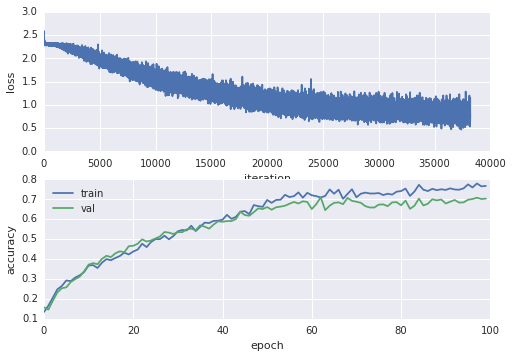

In [118]:
plt.subplot(2, 1, 1)
plt.plot(np.array(loss_history).clip(max=3))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [121]:
import pickle
with open('v1.pickle', 'wb') as f:
    pickle.dump(model, f, -1)

param

{'batch_size': 128,
 'crp_filter_size': 3,
 'crp_num_filters': 128,
 'fc_num_units': 256,
 'learning_rate': 0.0001,
 'learning_rate_decay': 0.95,
 'momentum': 0.9,
 'momentum_decay': 0.9,
 'num_crp': 3,
 'num_epochs': 100,
 'num_fc': 3,
 'reg': 0.001}

# v3: [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

# VGG-ish
* input: 32x32x3
* CONV3-64: 32x32x64
* CONV3-64: 32x32x64
* POOL2: 16x16x64
* CONV3-128: 16x16x128
* CONV3-128: 16x16x128
* POOL2: 8x8x128
* FC: 1x1x512
* FC: 1x1x512
* FC: 1x1x10

In [14]:
def create_v3(input_var, input_shape=(3, 32, 32),
              ccp_num_filters=[64, 128], ccp_filter_size=3,
              fc_num_units=[128, 128], num_classes=10,
              **junk):
    # input layer
    network = lasagne.layers.InputLayer(shape=(None,) + input_shape,
                                        input_var=input_var)
    # conv-relu-conv-relu-pool layers
    for num_filters in ccp_num_filters:
        network = lasagne.layers.Conv2DLayer(
            network, num_filters=num_filters,
            filter_size=(ccp_filter_size, ccp_filter_size),
            pad='same',
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
        network = lasagne.layers.Conv2DLayer(
            network, num_filters=num_filters,
            filter_size=(ccp_filter_size, ccp_filter_size),
            pad='same',
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
        network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    # fc-relu
    for num_units in fc_num_units:
        network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=num_units,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
    # output layer
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=num_classes,
        nonlinearity=lasagne.nonlinearities.softmax)
    return network

In [21]:

param = dict(ccp_num_filters=[64, 128], ccp_filter_size=3,
             fc_num_units=[256, 256], num_classes=10,
             learning_rate=1e-2, learning_rate_decay=0.5,
             momentum=0.9, momentum_decay=0.5,
             decay_after_epochs=10,
             batch_size=128, num_epochs=50)

In [23]:
network = create_v3(input_var, **param)
# overfit
xxx, loss_history, train_acc_history, val_acc_history = lasagne_trainer.train(
          network, input_var, X_train[:50], y_train[:50], X_val, y_val,
          learning_rate=1e-2, batch_size=10, num_epochs=30, decay_after_epochs=3)

Compiling...
Training...
epoch 1 / 30 in 0.8s: loss 3.247790, train: 0.160, val 0.110, lr 1.000000e-02 mom 9.000000e-01
epoch 2 / 30 in 0.8s: loss 2.458449, train: 0.160, val 0.119, lr 1.000000e-02 mom 9.000000e-01
epoch 3 / 30 in 0.8s: loss 2.399592, train: 0.180, val 0.088, lr 1.000000e-02 mom 9.000000e-01
epoch 4 / 30 in 0.8s: loss 2.211803, train: 0.160, val 0.079, lr 9.500000e-03 mom 9.050000e-01
epoch 5 / 30 in 0.8s: loss 2.236917, train: 0.200, val 0.122, lr 9.500000e-03 mom 9.050000e-01
epoch 6 / 30 in 0.8s: loss 2.406256, train: 0.300, val 0.156, lr 9.500000e-03 mom 9.050000e-01
epoch 7 / 30 in 0.8s: loss 2.243320, train: 0.360, val 0.162, lr 9.025000e-03 mom 9.097500e-01
epoch 8 / 30 in 0.8s: loss 2.254551, train: 0.320, val 0.158, lr 9.025000e-03 mom 9.097500e-01
epoch 9 / 30 in 0.8s: loss 2.170130, train: 0.320, val 0.145, lr 9.025000e-03 mom 9.097500e-01
epoch 10 / 30 in 0.8s: loss 2.164701, train: 0.360, val 0.126, lr 8.573750e-03 mom 9.142625e-01
epoch 11 / 30 in 0.8s: l

In [24]:
model, loss_history, train_acc_history, val_acc_history = lasagne_trainer.train(
    network, input_var, X_train, y_train, X_val, y_val,
    learning_rate=param['learning_rate'], learning_rate_decay=param['learning_rate_decay'],
    momentum=param['momentum'], momentum_decay=param['momentum_decay'],
    decay_after_epochs=param['decay_after_epochs'],
    batch_size=param['batch_size'], num_epochs=param['num_epochs'],
    save_path='net_v3')
print('%.3f' % min(loss_history), max(train_acc_history), max(val_acc_history), \
    ' '.join('%s=%s' % (k,param[k]) for k in param))

Compiling...
Training...
epoch 1 / 50 in 88.7s: loss 1.820408, train: 0.460, val 0.493, lr 1.000000e-02 mom 9.000000e-01
epoch 2 / 50 in 88.7s: loss 1.497272, train: 0.546, val 0.562, lr 1.000000e-02 mom 9.000000e-01
epoch 3 / 50 in 88.7s: loss 1.332127, train: 0.622, val 0.623, lr 1.000000e-02 mom 9.000000e-01
epoch 4 / 50 in 88.7s: loss 1.191845, train: 0.634, val 0.666, lr 1.000000e-02 mom 9.000000e-01
epoch 5 / 50 in 88.7s: loss 1.086699, train: 0.684, val 0.703, lr 1.000000e-02 mom 9.000000e-01
epoch 6 / 50 in 88.7s: loss 1.004664, train: 0.710, val 0.721, lr 1.000000e-02 mom 9.000000e-01
epoch 7 / 50 in 88.7s: loss 0.951341, train: 0.718, val 0.728, lr 1.000000e-02 mom 9.000000e-01
epoch 8 / 50 in 88.7s: loss 0.906197, train: 0.734, val 0.735, lr 1.000000e-02 mom 9.000000e-01
epoch 9 / 50 in 88.7s: loss 0.861574, train: 0.771, val 0.748, lr 1.000000e-02 mom 9.000000e-01
epoch 10 / 50 in 88.7s: loss 0.823561, train: 0.772, val 0.748, lr 1.000000e-02 mom 9.000000e-01
epoch 11 / 50 

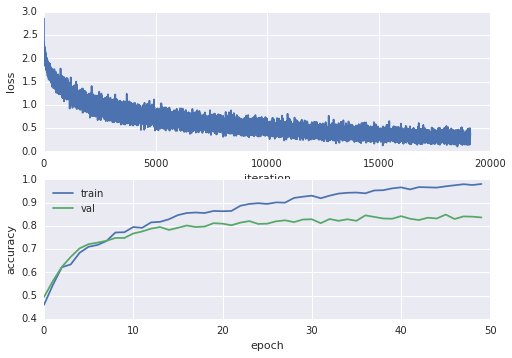

In [25]:
plt.subplot(2, 1, 1)
plt.plot(np.array(loss_history).clip(max=3))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()